In [1]:
from light_curve import LightCurve
import joblib
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from torchvision import transforms
import aug
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from keras.utils.np_utils import to_categorical

KeyboardInterrupt: 

In [ ]:
path_macho = '/home/francisco/Documents/SSL/data/macho/full.pkl'
data_macho = joblib.load(path_macho)
path_asas = '/home/francisco/Documents/SSL/data/asas/full.pkl'
data_asas = joblib.load(path_asas)
path_linear = '/home/francisco/Documents/SSL/data/linear/full.pkl'
data_linear = joblib.load(path_linear)

## Dataset


## Cargar datos,period fold y normalizacion

In [ ]:
all_data = data_macho + data_asas + data_linear

In [ ]:
max_value = max([lc.max_value() for lc in all_data])
min_value = min([lc.min_value() for lc in all_data])

In [ ]:
for lc in all_data:
    lc.normalize(min_value,max_value)
    lc.period_fold()
data_raw = [[lc.times,lc.measurements] for lc in all_data]
X_t = np.array(data_raw).transpose()



/tmp/ipykernel_15013/1791650327.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_t = np.array(data_raw).transpose()


In [ ]:
from scipy.signal import resample

In [ ]:
M_padded = [resample(x,500) for x in X_t[0]]
T_padded = [resample(x,500) for x in X_t[1]]

In [ ]:
X = np.array([[M_padded[i],T_padded[i]] for i in range(len(M_padded))])

76761

In [ ]:

classnames, y_inds = np.unique([str(lc.label) for lc in all_data],return_inverse=True)
Y = to_categorical(y_inds, len(classnames))

Y_lab = [list(np.where(p==1))[0][0] for p in Y]

In [ ]:
x = pd.DataFrame(Y_lab)

In [ ]:
x.value_counts()

19    44770
24     7403
9      6833
38     3499
28     3032
17     1766
25     1765
4      1185
14     1134
13      822
29      785
15      778
3       683
2       640
26      315
12      315
23      237
37      184
8       140
7       130
16       59
1        38
30       35
5        32
34       31
32       24
39       20
0        18
22       17
31       17
33       15
20       13
11        8
21        5
18        4
6         4
27        2
35        1
36        1
10        1
dtype: int64

## Training Encoder

In [ ]:
def train_epoch(model, dataloader, loss_function, optimizer):
  """Funcion para realizar el entrenamiento de una epoca
    Inputs
    -------
    model : torch.model
      modelo a entrenar
    dataloader: torch.dataloader
      datos con los cuales se entrena
    loss_function: torch.loss_fn
      funcion de perdida para el entrenamiento(entropia cruzada)
    optimizer: torch.optimizer
      funcion de optimizacion(adam)
    Returns
    -------
    list:
    entrega un tensor con los valores de ouputs entrenamiento, labels y losses
  """
  model.train()
  train_outputs = []
  train_labels = []
  train_losses = []

  for i,data in enumerate(dataloader):
    targets = data[1].cuda()
    sample = data[0].float().cuda()

    batch_size = targets.shape[0]

    outputs = model(sample)
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item()*batch_size)
    train_outputs.append(outputs.detach())
    train_labels.append(targets.detach())

  return torch.tensor(train_losses), torch.cat(train_outputs), torch.cat(train_labels)

In [ ]:
def val_epoch(model, dataloader, loss_function):
  """Funcion para realizar la validacion de una epoca
    Inputs
    -------
    model : torch.model
      modelo a entrenar
    dataloader: torch.dataloader
      datos con los cuales se entrena
    loss_function: torch.loss_fn
      funcion de perdida para el entrenamiento(entropia cruzada)
    Returns
    -------
    list:
    entrega un tensor con los valores de ouputs validacion, labels y losses
  """
  model.eval()
  val_outputs= []
  val_labels = []
  val_losses = []

  with torch.no_grad():
    for i,data in enumerate(dataloader):
      targets = data[1].cuda()
      sample = data[0].float().cuda()

      batch_size = targets.shape[0]

      outputs = model(sample)

      loss = loss_function(outputs, targets)

      val_losses.append(loss.item()*batch_size)
      val_outputs.append(outputs.detach())
      val_labels.append(targets.detach())

  return torch.tensor(val_losses), torch.cat(val_outputs), torch.cat(val_labels)

In [ ]:
def get_scores(losses, outputs, labels):
  """Funcion obtener escores a partir de losses outputs y labels
  Inputs
  -------
  losses : list
    lista de losses
  outputs : list
    lista de outputs
  labels : list
    lista con los labels
  Returns
  -------
  acc: float
    valor de accuracy
  loss: float
    valor de loss
  
    """
  pred = torch.argmax(outputs, dim=1).cpu().numpy()
  true_label = labels.cpu().numpy()
  num = labels.shape[0]
  loss = torch.sum(losses).item()/num
  acc = accuracy_score(true_label, pred)
  return loss, acc

In [ ]:
def curva_entrenamiento(loss_train, loss_val, titulo):
  """Funcion que permite graficar la curva de entrenamiento
  Inputs
  -------
  loss_train : list
    lista de losses entrenamiento
  loss_val : list
    lista de losses validacion
  titulo : str
    titulo del grafico

  """
  epochs = len(loss_train)
  epoch_list = np.arange(1, epochs+1)
  plt.plot(epoch_list, loss_train, label = "Train")
  plt.plot(epoch_list, loss_val, label = "Validation")
  plt.legend()
  plt.title(titulo)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

In [ ]:
import torch.nn.functional as F
class MyNet4(nn.Module):


  def __init__(self):
    super(MyNet4, self).__init__()#(32,32,3)
    
    self.nclasses = 10
    self.conv1 = nn.Conv1d(2, 64, kernel_size=3, padding=1)  #(64,64,64)
    self.bn1 = nn.BatchNorm1d(64)
    self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1) #(64,64,64)
    self.bn2 = nn.BatchNorm1d(64)
    self.mpool1 = nn.MaxPool1d(kernel_size = 2, stride = 2) #(64,32,32)
    self.conv3 = nn.Conv1d(64,64, kernel_size=3, padding=1) #(64,32,32)
    self.bn3 = nn.BatchNorm1d(64)
    self.conv4 = nn.Conv1d(64,64, kernel_size=3, padding=1)#(64,32,32)
    self.bn4 = nn.BatchNorm1d(64)
    self.conv5 = nn.Conv1d(64,64, kernel_size=3, padding=1)#(64,32,32)
    self.bn5 = nn.BatchNorm1d(64)
    self.mpool2 = nn.MaxPool1d(kernel_size = 2, stride = 2) #(64,16,16)
    self.fc1 = nn.Linear(8000, 2048)
    self.fc2 = nn.Linear(2048, 1024)
    
  def forward(self, x):

    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.mpool1(x)
    x = self.bn3(F.relu(self.conv3(x)))
    x = self.bn4(F.relu(self.conv4(x)))
    x = self.bn5(F.relu(self.conv5(x)))
    x = self.mpool2(x)
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
BATCH_SIZE = 64
LR = 1e-3
epochs = 20

In [ ]:
device ='cuda'

In [ ]:
encoder = MyNet4()
encoder.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr=LR)

In [ ]:
x_tot, x_enc, y_tot, y_enc = train_test_split(X,Y_lab,test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(X,Y_lab,test_size=0.2)
data_train = [y_train,x_train]
data_val = [y_val,x_val]

In [ ]:
class data_LC(Dataset):
    def __init__(self,input,label,device='cuda'):
        self.data = torch.tensor(input,dtype=torch.float)
        self.labels = torch.tensor(label)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        return self.data[index],self.labels[index]

In [ ]:
dataset_train = data_LC(x_train,y_train)
dataset_val = data_LC(x_val,y_val)
train_loader_base = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle =True, pin_memory=True)
val_loader_base = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle =True, pin_memory=True)


In [ ]:
best_param_net3_path = 'best_param_encoder.bin'

In [ ]:
best_val_loss = np.inf
loss_train = []
loss_val = []
not_improve_epochs = 0
tolerance = 5
epoch = 0
while not_improve_epochs<tolerance:
  epoch+=1
  print(f"Epoch {epoch}/{epochs}")
  train_loss, train_out, train_targets = train_epoch(encoder, train_loader_base, criterion, optimizer)
  loss, acc = get_scores(train_loss, train_out, train_targets)
  loss_train.append(loss)
  print("Train Loss: {:.3f}\tTrain Acc: {:.3f}".format(loss, acc))

  val_loss, val_out, val_targets = val_epoch(encoder, val_loader_base, criterion)
  loss, acc = get_scores(val_loss, val_out, val_targets)
  loss_val.append(loss)
  print("Validation Loss: {:.3f}\tValidation Acc: {:.3f}".format(loss, acc))

  if loss < best_val_loss :
    torch.save(encoder.state_dict(),best_param_net3_path)
    best_val_loss = loss
    not_improve_epochs=0
  else:
    not_improve_epochs+=1

Epoch 1/20
Train Loss: 0.649	Train Acc: 0.806
Validation Loss: 1.735	Validation Acc: 0.454
Epoch 2/20
Train Loss: 0.466	Train Acc: 0.842
Validation Loss: 1.060	Validation Acc: 0.709
Epoch 3/20
Train Loss: 0.439	Train Acc: 0.849
Validation Loss: 1.782	Validation Acc: 0.513
Epoch 4/20
Train Loss: 0.428	Train Acc: 0.853
Validation Loss: 0.890	Validation Acc: 0.715
Epoch 5/20
Train Loss: 0.419	Train Acc: 0.855
Validation Loss: 0.943	Validation Acc: 0.720
Epoch 6/20
Train Loss: 0.406	Train Acc: 0.858
Validation Loss: 1.584	Validation Acc: 0.654
Epoch 7/20
Train Loss: 0.412	Train Acc: 0.857
Validation Loss: 0.502	Validation Acc: 0.837
Epoch 8/20
Train Loss: 0.400	Train Acc: 0.859
Validation Loss: 1.303	Validation Acc: 0.620
Epoch 9/20
Train Loss: 0.393	Train Acc: 0.861
Validation Loss: 1.463	Validation Acc: 0.674
Epoch 10/20
Train Loss: 0.391	Train Acc: 0.862
Validation Loss: 1.552	Validation Acc: 0.657
Epoch 11/20
Train Loss: 0.384	Train Acc: 0.864
Validation Loss: 1.121	Validation Acc: 0.7

In [ ]:
encoder.load_state_dict(torch.load(best_param_net3_path))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

/home/francisco/anaconda3/envs/cl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/francisco/anaconda3/envs/cl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/francisco/anaconda3/envs/cl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

                   precision    recall  f1-score   support

      Beta_Cephei      0.000     0.000     0.000        15
       Beta_Lyrae      0.000     0.000     0.000        34
      Beta_Persei      0.450     0.101     0.165       534
         Ceph 1st      0.603     0.314     0.413       561
        Ceph Fund      0.724     0.664     0.693       952
     ChemPeculiar      0.000     0.000     0.000        24
     ClassT_Tauri      0.000     0.000     0.000         4
Classical_Cepheid      0.000     0.000     0.000       106
      Delta_Scuti      0.980     0.436     0.604       110
               EB      0.751     0.768     0.759      5440
      Ellipsoidal      0.000     0.000     0.000         1
      Herbig_AEBE      0.000     0.000     0.000         6
        LPV WoodA      0.790     0.187     0.302       262
        LPV WoodB      0.517     0.092     0.156       662
        LPV WoodC      0.522     0.425     0.468       880
        LPV WoodD      0.452     0.968     0.617       

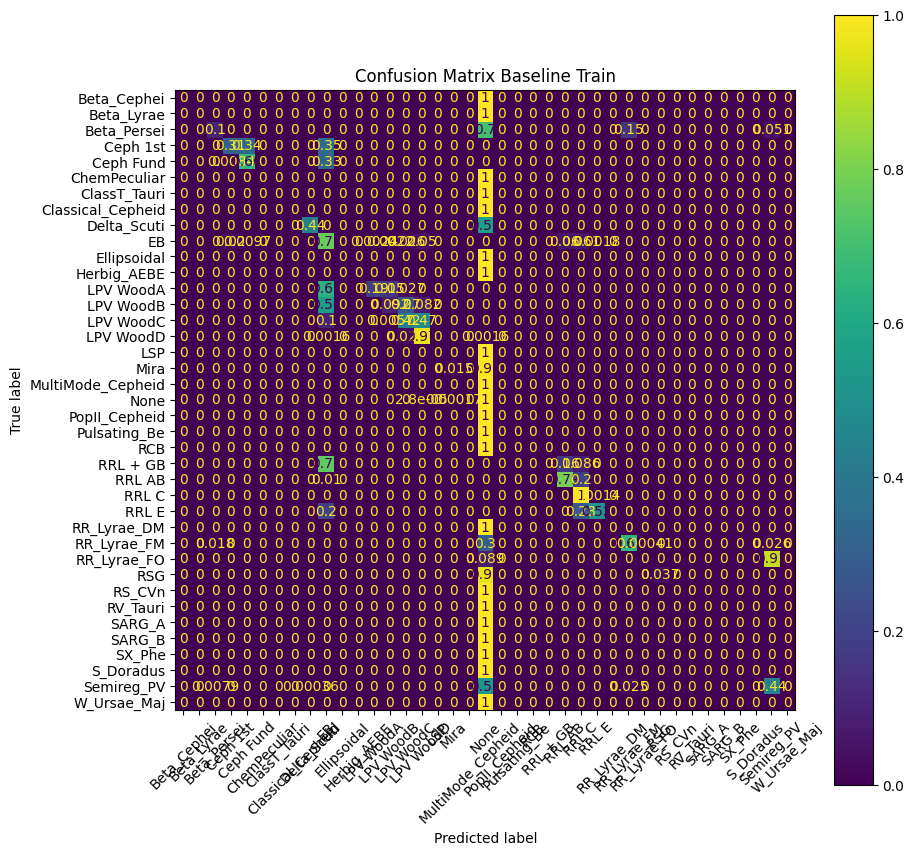

In [ ]:
loss, preds, targets = val_epoch(encoder, train_loader_base, criterion)

preds = torch.argmax(preds, dim=1).cpu().numpy()
targets = targets.cpu().numpy()

print(classification_report(targets, preds, target_names =  classnames[0:39],digits=3))

conf_m = confusion_matrix(targets, preds, normalize='true')
cmp=ConfusionMatrixDisplay(conf_m,display_labels = classnames[0:39])
fig, ax = plt.subplots(figsize=(10,10))
title = 'Confusion Matrix Baseline Train'
ax.set_title(title)
fig.set_facecolor('white')
cmp.plot(ax=ax,xticks_rotation=45)

## Train Self-Supervised

In [ ]:
class NormalizedEuclideanDistance(object):
    def __init__(self, dim, eps=1e-6):
        self.dim = dim
        self.eps = eps

    def __call__(self, x, y):
        z = (x - y).pow(2).sum(1) / self.dim
        return z, (z + self.eps).sqrt()

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1, distance_fun_name='euclidean', nl=16):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.distance_fun_name = distance_fun_name
        if self.distance_fun_name == "euclidean":
            self.forward_fun = self.contrastive_with_euclidean
            self.norm_euclidean_distance = NormalizedEuclideanDistance(nl)
        elif self.distance_fun_name == "cosine":
            self.forward_fun = self.contrastive_with_cosine
            self.cosine_distance = torch.nn.CosineSimilarity()
        self.relu = torch.nn.ReLU()

    def contrastive_with_cim(self, x1, x2, y_bar):
        cim2, cim = self.cim(x1, x2)
        loss = 0.5 * (1 - y_bar) * cim2 + 0.5 * y_bar * self.relu(self.margin - cim).pow(2)
        return loss.mean()

    def contrastive_with_euclidean(self, x1, x2, y_bar):
        dw2, dw = self.norm_euclidean_distance(x1, x2)
        loss = 0.5 * (1 - y_bar) * dw2 + 0.5 * y_bar * self.relu(self.margin - dw).pow(2)
        return loss.mean()

    def contrastive_with_cosine(self, x1, x2, y_bar):
        dw = 1 - self.cosine_distance(x1, x2)
        loss = 0.5 * ((1 - y_bar) * dw + y_bar * self.relu(self.margin - dw))
        return loss.mean()

    def forward(self, z, y):
        indices1 = torch.randperm(len(z))
        indices2 = torch.randperm(len(z))
        y_bar = torch.logical_or(y[indices1] != y[indices2], (y[indices1] == -99) * (y[indices2] == -99)) * 1.
        loss = self.forward_fun(z[indices1], z[indices2], y_bar)
        return loss

In [ ]:
def train_epoch_ssl(model, dataloader, loss_function, optimizer):
  """Funcion para realizar el entrenamiento de una epoca
    Inputs
    -------
    model : torch.model
      modelo a entrenar
    dataloader: torch.dataloader
      datos con los cuales se entrena
    loss_function: torch.loss_fn
      funcion de perdida para el entrenamiento(entropia cruzada)
    optimizer: torch.optimizer
      funcion de optimizacion(adam)
    Returns
    -------
    list:
    entrega un tensor con los valores de ouputs entrenamiento, labels y losses
  """
  model.train()
  train_outputs = []
  train_labels = []
  train_losses = []

  for data in dataloader:
    targets = data[1].cuda()
    sample = data[0].float().cuda()
    seq_len = data[2]
    batch_size = targets.shape[0]

    outputs = model([sample[0],sample[1],seq_len])
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item()*batch_size)
    train_outputs.append(outputs.detach())
    train_labels.append(targets.detach())

  return torch.tensor(train_losses), torch.cat(train_outputs), torch.cat(train_labels)

In [ ]:
def val_epoch_ssl(model, dataloader, loss_function):
  """Funcion para realizar la validacion de una epoca
    Inputs
    -------
    model : torch.model
      modelo a entrenar
    dataloader: torch.dataloader
      datos con los cuales se entrena
    loss_function: torch.loss_fn
      funcion de perdida para el entrenamiento(entropia cruzada)
    Returns
    -------
    list:
    entrega un tensor con los valores de ouputs validacion, labels y losses
  """
  model.eval()
  val_outputs= []
  val_labels = []
  val_losses = []

  with torch.no_grad():
    for data in dataloader:
      targets = data[1].cuda()
      sample = data[0].float().cuda()
      seq_len = data[2]
      batch_size = targets.shape[0]

      outputs = model([sample[0],sample[1],seq_len])

      loss = loss_function(outputs, targets)

      val_losses.append(loss.item()*batch_size)
      val_outputs.append(outputs.detach())
      val_labels.append(targets.detach())

  return torch.tensor(val_losses), torch.cat(val_outputs), torch.cat(val_labels)

In [ ]:
best_val_loss = np.inf
loss_train = []
loss_val = []
not_improve_epochs = 0
tolerance = 5
epoch = 0
while not_improve_epochs<tolerance:
  epoch+=1
  print(f"Epoch {epoch}/{epochs}")
  train_loss, train_out, train_targets = train_epoch_ssl(encoder, train_loader_base, criterion, optimizer)
  loss, acc = get_scores(train_loss, train_out, train_targets)
  loss_train.append(loss)
  print("Train Loss: {:.3f}\tTrain Acc: {:.3f}".format(loss, acc))

  val_loss, val_out, val_targets = val_epoch_ssl(encoder, val_loader_base, criterion)
  loss, acc = get_scores(val_loss, val_out, val_targets)
  loss_val.append(loss)
  print("Validation Loss: {:.3f}\tValidation Acc: {:.3f}".format(loss, acc))

  if loss < best_val_loss :
    torch.save(encoder.state_dict(),best_param_net3_path)
    best_val_loss = loss
    not_improve_epochs=0
  else:
    not_improve_epochs+=1

In [ ]:
a = 2